# 多层感知机

##  隐藏层

## 激活函数
- 激活函数（activation function）通过计算加权和并加上偏置来确定神经元是否应该被激活， 它们将输入信号转换为输出的可微运算。 
- 大多数激活函数都是非线性的。 

In [2]:
!git clone https://github.com/d2l-ai/d2l-zh.git
!cp -r d2l-zh/d2l ./

Cloning into 'd2l-zh'...
remote: Enumerating objects: 23869, done.
remote: Total 23869 (delta 0), reused 0 (delta 0), pack-reused 23869
Receiving objects: 100% (23869/23869), 287.46 MiB | 34.90 MiB/s, done.
Resolving deltas: 100% (16726/16726), done.


In [3]:
import torch
from d2l import torch as d2l

## ReLU函数

$$\operatorname{ReLU}(x)=\max (x, 0)$$

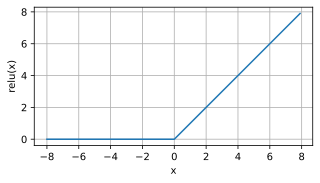

In [4]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.relu(x)
d2l.plot(x.detach(), y.detach(), 'x', 'relu(x)', figsize=(5, 2.5))

## ReLU函数的导数

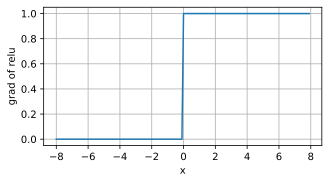

In [5]:
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of relu', figsize=(5, 2.5))

## Parameterized ReLU，pReLU

$$
\mathrm{pReLU}(x)=\max (0, x)+\alpha \min (0, x)
$$

## sigmoid函数

$$
\operatorname{sigmoid}(x)=\frac{1}{1+\exp (-x)}
$$

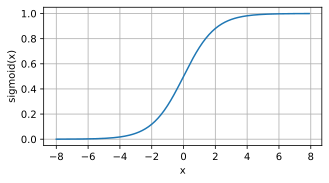

In [7]:
y = torch.sigmoid(x)
d2l.plot(x.detach(), y.detach(), 'x', 'sigmoid(x)', figsize=(5, 2.5))

## sigmoid函数的导数

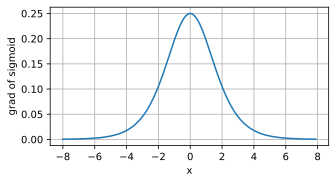

In [8]:
# 清除以前的梯度
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of sigmoid', figsize=(5, 2.5))

## tanh函数

$$
\tanh (x)=\frac{1-\exp (-2 x)}{1+\exp (-2 x)}
$$

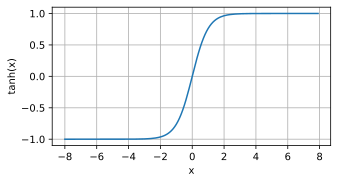

In [10]:
y = torch.tanh(x)
d2l.plot(x.detach(), y.detach(), 'x', 'tanh(x)', figsize=(5, 2.5))

## tanh函数的导数

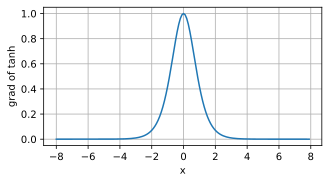

In [11]:
# 清除以前的梯度
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of tanh', figsize=(5, 2.5))

## 多层感知机的简洁实现

In [13]:
import torch
from torch import nn
from d2l import torch as d2l

In [14]:
net = nn.Sequential(nn.Flatten(),
                    nn.Linear(784, 256),
                    nn.ReLU(),
                    nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=10, bias=True)
)

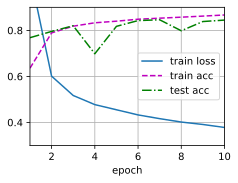

In [15]:
batch_size, lr, num_epochs = 256, 0.1, 10
loss = nn.CrossEntropyLoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=lr)

train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

## 模型选择、欠拟合和过拟合

- 过拟合:模型训练集效果好，测试机效果差
- 欠拟合:模型训练集效果差，测试机效果好
- 训练误差:型在训练数据集上计算得到的误差
- 泛化误差:模型应用在同样从原始样本的分布中抽取的无限多数据样本时，模型误差的期望
- 影响模型泛化的因素
    - 可调整参数的数量。当可调整参数的数量（有时称为自由度）很大时，模型往往更容易过拟合。
    -参数采用的值。当权重的取值范围较大时，模型可能更容易过拟合。
    - 训练样本的数量。即使模型很简单，也很容易过拟合只包含一两个样本的数据集。而过拟合一个有数百万个样本的数据集则需要一个极其灵活的模型。
- 验证集:在我们确定所有的超参数之前，我们不希望用到测试集
- $K$折交叉验证
    - 原始训练数据被分成 $K$个不重叠的子集,然后执行 $K$次模型训练和验证，每次在 $K-1$个子集上进行训练， 并在剩余的一个子集（在该轮中没有用于训练的子集）上进行验证。 最后，通过对 $K$次实验的结果取平均来估计训练和验证误差。

## 多项式回归

In [17]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

## 生成数据集

$$
y=5+1.2 x-3.4 \frac{x^2}{2 !}+5.6 \frac{x^3}{3 !}+\epsilon \text { where } \epsilon \sim \mathcal{N}\left(0,0.1^2\right)
$$

In [19]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间

In [21]:
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

In [22]:
true_w

array([ 5. ,  1.2, -3.4,  5.6,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ])

In [52]:

features = np.random.normal(size=(n_train + n_test, 1))
#np.random.normal(size=(200, 1))
np.random.shuffle(features) 

poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))

for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!

labels = np.dot(poly_features, true_w)

# 添加偏置
labels += np.random.normal(scale=0.1, size=labels.shape)

In [53]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[-0.6829],
         [-0.5910]]),
 tensor([[ 1.0000e+00, -6.8294e-01,  2.3320e-01, -5.3087e-02,  9.0638e-03,
          -1.2380e-03,  1.4091e-04, -1.3748e-05,  1.1736e-06, -8.9056e-08,
           6.0820e-09, -3.7760e-10,  2.1490e-11, -1.1289e-12,  5.5071e-14,
          -2.5073e-15,  1.0702e-16, -4.2993e-18,  1.6312e-19, -5.8632e-21],
         [ 1.0000e+00, -5.9100e-01,  1.7464e-01, -3.4404e-02,  5.0832e-03,
          -6.0084e-04,  5.9183e-05, -4.9967e-06,  3.6913e-07, -2.4240e-08,
           1.4326e-09, -7.6969e-11,  3.7907e-12, -1.7233e-13,  7.2749e-15,
          -2.8663e-16,  1.0587e-17, -3.6807e-19,  1.2085e-20, -3.7591e-22]]),
 tensor([3.0241, 3.4413]))

## 对模型进行训练和测试

In [60]:
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [61]:
def train(train_features,test_features,
          train_labels,test_labels,num_epochs = 400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape,1,bias = False))
    batch_size = min(10,train_labels.shape[0])
    train_iter = d2l.load_array((train_features,train_labels.reshape(-1,1)),batch_size)
    test_iter = d2l.load_array((test_features,test_labels.reshape(-1,1)),batch_size,is_train = False)
    animator = d2l.Animator(xlabel = 'epoch',ylabel = 'loss',yscale = 'log',
                           xlim = [1,num_epochs],ylim = [1e-3,1e2],
                           legend = ['train','test'])
    trainer = torch.optim.SGD(net.parameters(),lr = 0.01)
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net,train_iter,loss,trainer)
        if epoch==0 or (epoch+1)%20 ==0:
            animator.add(epoch+1,(evaluate_loss(net,train_iter,loss),
                                 (evaluate_loss(net,test_iter,loss))))
    print('weight:',net[0].weight.data.numpy())

weight: [[ 4.9995112  1.2149142 -3.4182196  5.5455017]]


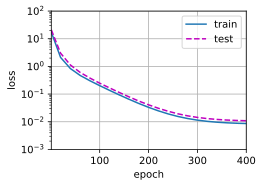

In [68]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

In [67]:
true_w

tensor([ 5.0000,  1.2000, -3.4000,  5.6000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000])

# 权重衰减

## 高维线性回归

In [3]:
import torch
from torch import nn
from d2l import torch as d2l

$$
y=0.05+\sum_{i=1}^d 0.01 x_i+\epsilon \text { where } \epsilon \sim \mathcal{N}\left(0,0.01^2\right)
$$

In [4]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

## 初始化模型参数

In [6]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

## 定义$L_2$范数惩罚

In [8]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

## 定义训练代码实现

In [9]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # 增加了L2范数惩罚项，
            # 广播机制使l2_penalty(w)成为一个长度为batch_size的向量
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(w).item())

w的L2范数是： 14.253631591796875


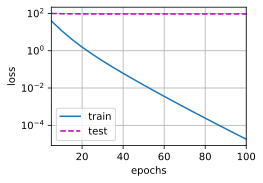

In [10]:
train(lambd=0)

w的L2范数是： 0.37719419598579407


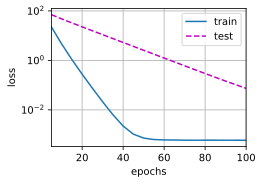

In [11]:
train(lambd=3)

## 简洁实现

In [12]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd},
        {"params":net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1,
                         (d2l.evaluate_loss(net, train_iter, loss),
                          d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())

w的L2范数： 13.198836326599121


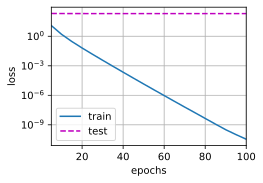

In [13]:
train_concise(0)

w的L2范数： 0.3540521264076233


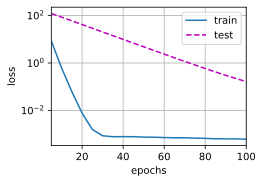

In [14]:
train_concise(3)